In [373]:
#######################
##  Library Imports  ##
#######################
import numpy as np
import h5py as h5
import sys
import os
from numba import njit
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = 'Computer Modern Roman'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getopt
from itertools import zip_longest
import multiprocessing as mprocs
import time as TIME
from subprocess import Popen, PIPE
from matplotlib.pyplot import cm
from functions import tc, import_data, sim_data, import_data, import_spectra_data, import_post_processing_data

## Helper Functions

In [374]:
def spectra_accum(spec):
    spec_accum = np.empty_like(spec)
    spec_accum[0] = spec[0]
    for i in range(1, spec.shape[0]):
        spec_accum[i] = spec[i]
        spec_accum[i] += spec_accum[i - 1]
        
    return spec_accum

## Read in Data

In [454]:
data = "DECAY"
# data = "MAX_PALIN"
# data = "EXTRM_ENS"

In [462]:
if data == "DECAY":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[16,16]_T[0-5]_NU[0.000031]_CFL[0.90]_u0[DECAY_TURB_ALT]_TAG[Test-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[1]_KFRAC[0.75]_TAG[Test-Test].h5"
elif data == "MAX_PALIN":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.001000]_CFL[0.90]_u0[MAX_PALIN]_TAG[Max-Palin-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[1]_KFRAC[0.75]_TAG[Max-Palin-Test].h5"
elif data == "EXTRM_ENS":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.000010]_CFL[0.90]_u0[EXTRM_ENS]_TAG[Extrm-Enst-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[1]_KFRAC[0.75]_TAG[Extrm-Enst-Test].h5"

In [463]:
# -----------------------------------------
# # --------  Read In data
# -----------------------------------------
## Read in simulation parameters
sys_vars = sim_data(in_dir)

## Read in solver data
run_data = import_data(in_dir, sys_vars)

## Read in spectra data
spec_data = import_spectra_data(in_dir, sys_vars)

## Read in post processing data
post_data = import_post_processing_data(post_file_path, sys_vars, 'file')


# sys_vars, run_data, spec_data, sync_data, post_data = import_data(in_dir, post_file_path)


Preparing real space vorticity... Finished!


In [471]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[1]_KFRAC[0.75].h5') as f:
    num_wave_vec = f["NumWavevectors"]
    wave_vec_data_a0_l0 = f["WavevectorData_a[0]_l[0]"][:, :]
print(wave_vec_data_a0_l0.shape)
print(wave_vec_data_a0_l0[-1, :])

(16, 624)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0

In [472]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[2]_KFRAC[0.75].h5') as f:
    num_wave_vec = f["NumWavevectors"]
    wave_vec_data_a0_l0 = f["WavevectorData_a[0]_l[0]"][:, :]
    wave_vec_data_a0_l1 = f["WavevectorData_a[0]_l[1]"][:, :]    
    wave_vec_data_a1_l0 = f["WavevectorData_a[1]_l[0]"][:, :]    
    wave_vec_data_a1_l1 = f["WavevectorData_a[1]_l[1]"][:, :]  
    
print(wave_vec_data_a0_l0.shape)
print(wave_vec_data_a0_l1.shape)
print(wave_vec_data_a1_l0.shape)
print(wave_vec_data_a1_l1.shape)

print(wave_vec_data_a0_l0.shape[1] + wave_vec_data_a0_l1.shape[1], wave_vec_data_a1_l0.shape[1] + wave_vec_data_a1_l1.shape[1], wave_vec_data_a0_l0.shape[1] + wave_vec_data_a0_l1.shape[1] == wave_vec_data_a1_l0.shape[1] + wave_vec_data_a1_l1.shape[1])
print(wave_vec_data_a0_l0[-1, :])

(16, 136)
(16, 62)
(16, 184)
(16, 56)
198 240 False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]


In [466]:
for i in range(100):
    print(wave_vec_data_a0_l0[:6, -i], wave_vec_data_a1_l0[:6, -i], wave_vec_data_a0_l0[:6, -i] == wave_vec_data_a1_l0[:6, -i])

[-4.  0. -1.  0. -5.  0.] [0. 1. 0. 4. 0. 5.] [False False False False False False]
[-1.  3. -1.  1. -2.  4.] [4. 0. 1. 0. 5. 0.] [False False False False False False]
[-1.  2. -1.  2. -2.  4.] [ 3.  2.  2. -2.  5.  0.] [False  True False False False False]
[-1.  1. -1.  3. -2.  4.] [ 3.  1.  2. -1.  5.  0.] [False  True False False False False]
[-1.  4. -1. -4. -2.  0.] [3. 0. 2. 0. 5. 0.] [False False False False False  True]
[-1. -4. -1.  4. -2.  0.] [ 3. -1.  2.  1.  5.  0.] [False False False False False  True]
[-1. -1. -1. -3. -2. -4.] [ 3. -2.  2.  2.  5.  0.] [False False False False False False]
[-1. -2. -1. -2. -2. -4.] [ 2.  2.  3. -2.  5.  0.] [False False False  True False False]
[-1. -3. -1. -1. -2. -4.] [ 2.  1.  3. -1.  5.  0.] [False False False  True False False]
[-1.  3. -2.  1. -3.  4.] [2. 0. 3. 0. 5. 0.] [False False False False False False]
[-1.  2. -2.  2. -3.  4.] [ 2. -1.  3.  1.  5.  0.] [False False False False False False]
[-1.  1. -2.  3. -3.  4.] [ 2. -2.

## Enstorphy Flux Compare: Nonlinear Term vs Simple Sectors

In [467]:
const_fac_sector = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

0


In [468]:
print("Test Type 0")
print((post_data.enst_flux_per_sec[:, 0, theta]  * const_fac_sector * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))

print()
triad_type = 4
print("Specific Triad Type = {}".format(triad_type))
print((post_data.enst_flux_per_sec[:, triad_type, theta]) / (post_data.enst_flux_test[:, triad_type]))

print()
print(post_data.enst_flux_per_sec[:, :, :].shape)

Test Type 0
[  0.82940683   0.83217866   0.83497819   0.83780644   0.8406645
   0.84355351   0.84647468   0.84942929   0.85241868   0.85544428
   0.85850759   0.86161022   0.86475384   0.86794022   0.87117126
   0.87444893   0.87777535   0.88115272   0.88458342   0.88806993
   0.89161488   0.89522107   0.89889146   0.90262919   0.90643757
   0.91032015   0.91428066   0.91832308   0.92245164   0.92667082
   0.9309854    0.93540048   0.93992145   0.94455411   0.94930461
   0.95417953   0.9591859    0.96433123   0.96962357   0.97507155
   0.98068442   0.98647213   0.99244535   0.99861559   1.00499525
   1.01159772   1.01843746   1.02553013   1.03289271   1.04054363
   1.04850296   1.05679252   1.06543618   1.07446002   1.08389263
   1.0937654    1.10411292   1.11497331   1.12638876   1.13840607
   1.15107727   1.16446039   1.17862037   1.1936301    1.20957166
   1.22653788   1.24463409   1.26398033   1.28471403   1.30699326
   1.33100076   1.35694899   1.38508637   1.41570528   1.44915223

IndexError: index 1 is out of bounds for axis 2 with size 1

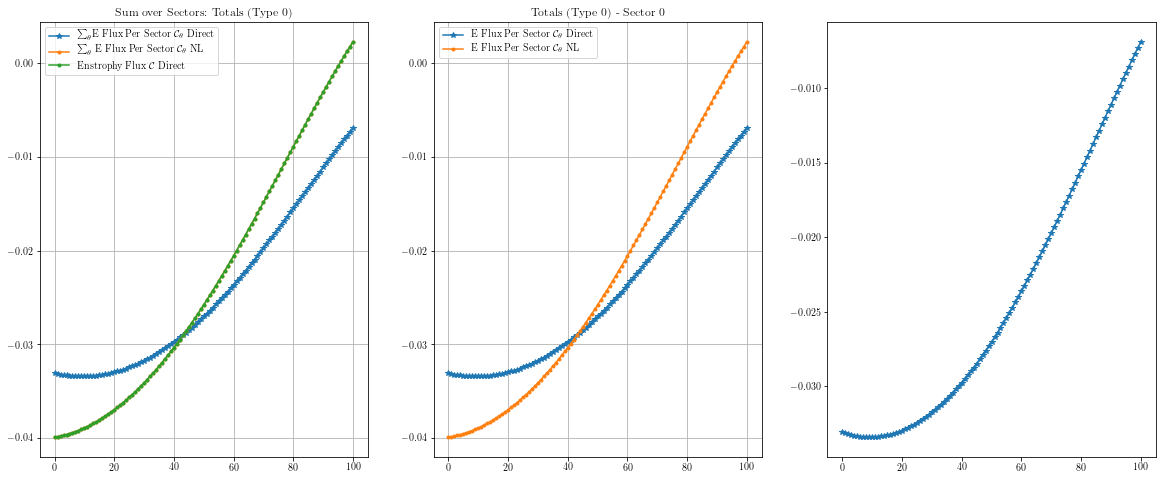

In [469]:
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 3)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac_sector * norm_fac, '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '.-')
ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$ Direct"])

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac_sector * norm_fac, '*-')
ax1.plot(post_data.enst_flux_C_theta[:, theta], '.-')
ax1.set_title(r"Totals (Type 0) - Sector {}".format(theta))
ax1.grid()
ax1.legend([r"E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$"])


ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(post_data.enst_flux_per_sec[:, 0, 0] * const_fac_sector * norm_fac, '*-')
ax3.plot(post_data.enst_flux_per_sec[:, 0, 1] * const_fac_sector * norm_fac, '*-')
ax3.legend([r"Bottom", r"Top"])
print(post_data.enst_flux_per_sec[:, 0, 0] / post_data.enst_flux_per_sec[:, 0, 1])
plt.show()

#### Triad Types Compare: Sectors vs All

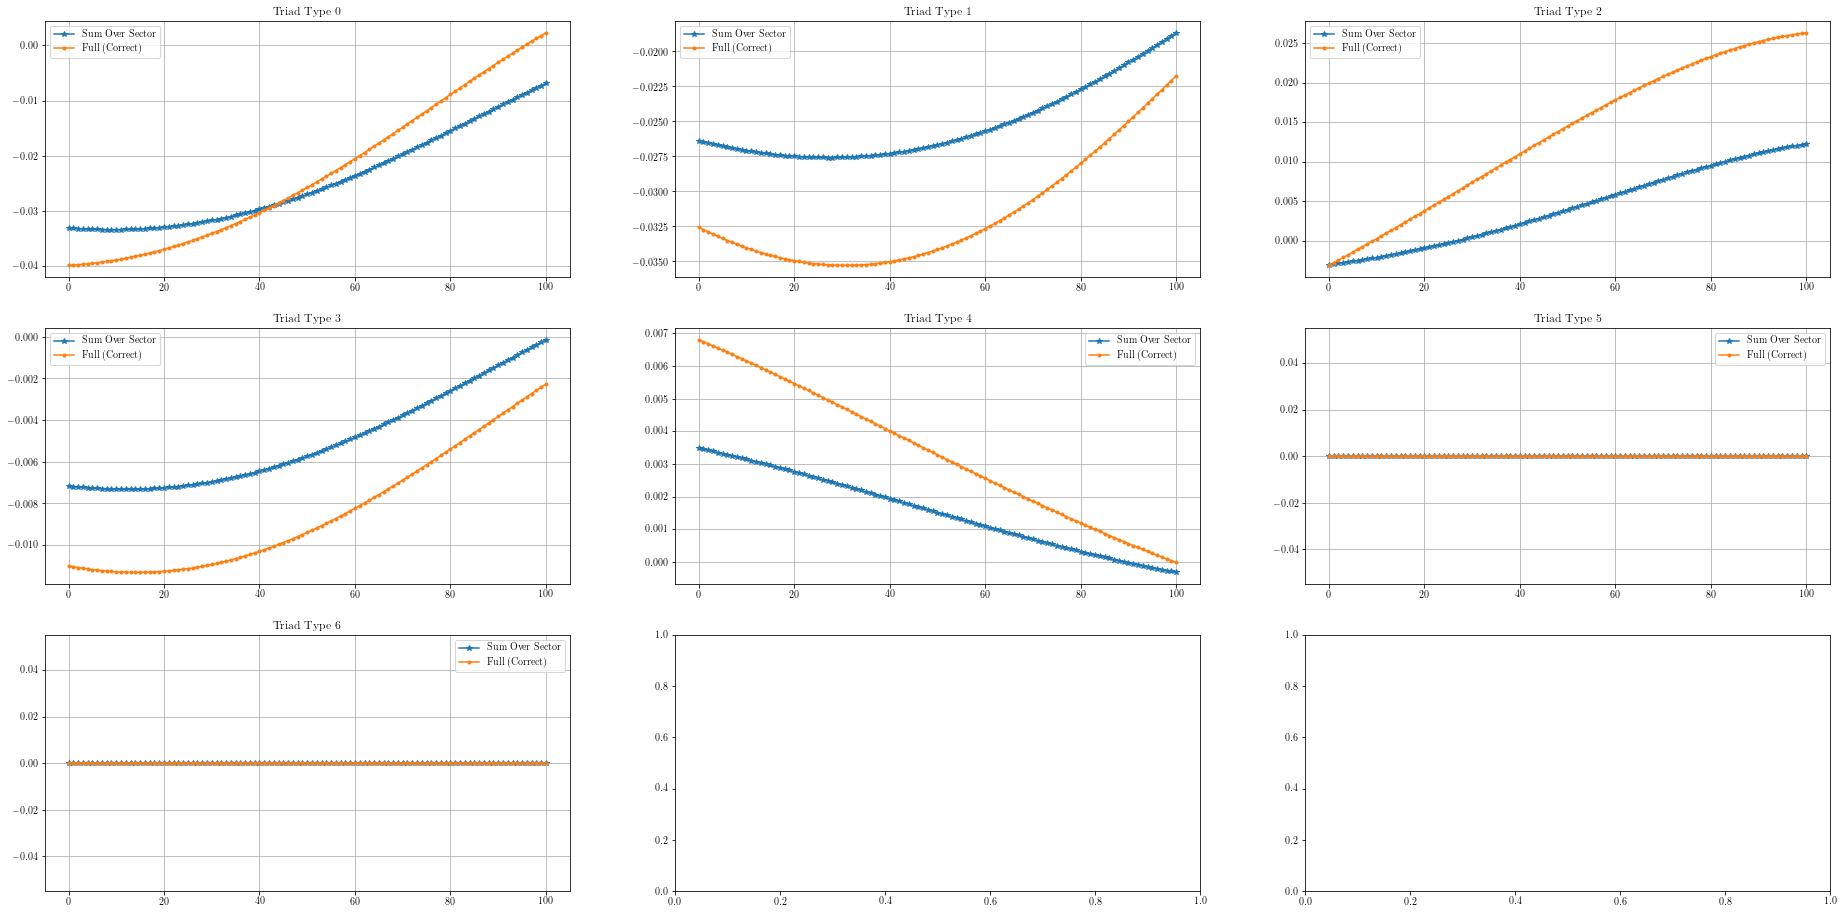

In [470]:
fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(3, 3)
ax1 = []
for i in range(3):
    for j in range(3):
        ax1.append(fig.add_subplot(gs[i, j]))
for i in range(post_data.enst_flux_per_sec.shape[1]):
    ax1[i].plot(np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac , '*-')
    ax1[i].plot(post_data.enst_flux_test[:, i] * const_fac * norm_fac, '.-')
    ax1[i].set_title(r"Triad Type {}".format(i))
#     ax1[i].set_xlim(-1, 20)
    ax1[i].legend([r"Sum Over Sector", r"Full (Correct)"])
    ax1[i].grid()

plt.show()

#### Compare Individual Sectors: Direct vs NL

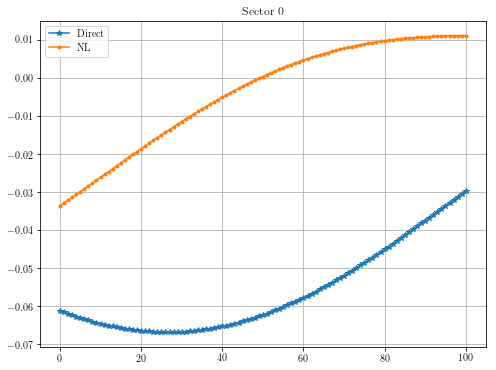

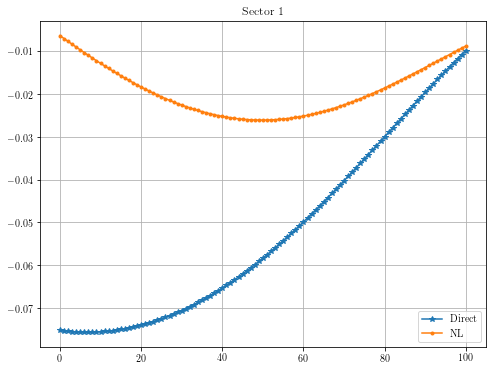

In [450]:
for a in range(post_data.num_sect):
    fig = plt.figure(figsize = (8, 6))
    gs  = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac, '*-')
    ax.plot(post_data.enst_flux_C_theta[:, a], '.-')
    ax.set_title(r"Sector {}".format(a))
    ax.legend([r"Direct", r"NL"])
    ax.grid()
    plt.show()

## Compare Enstorphy Flux Computed From Nonlinear Term and Directly - Ignoring Sectors

In [417]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

In [418]:
## Find the constant
print((post_data.enst_flux_test[:, 0] * const_fac * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
print()
print(const_fac)
print(norm_fac)
print(1 / (14000 * .29257143))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]

39.47841760435743
2.9802322387695312e-08
0.00024414062380790708


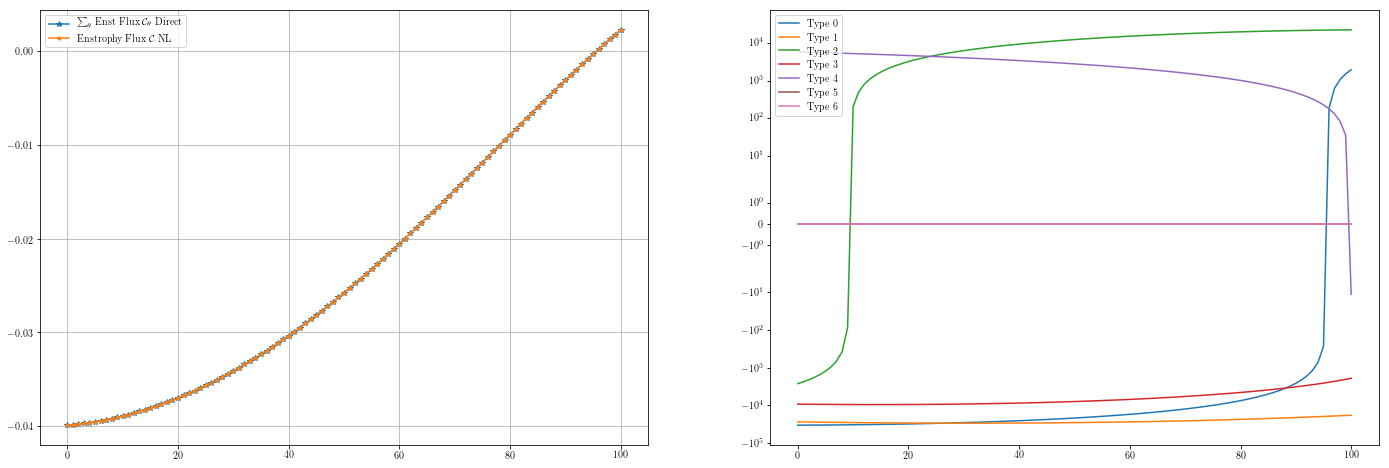

In [419]:
fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '*-')
ax1.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '.-')
# ax1.plot(post_data.enst_flux_C[:], '.-')
ax1.grid()
ax1.legend([r"$\sum_\theta$ Enst Flux $\mathcal{C}_\theta$ Direct", r"Enstrophy Flux $\mathcal{C}$ NL", r"Enstrophy Flux $\mathcal{C}$"])

ax2 = fig.add_subplot(gs[0, 1])
for i in range(post_data.triad_R_test.shape[1]):
    ax2.plot(post_data.enst_flux_test[:, i])
# ax2.set_yscale('log')
ax2.legend([r"Type {}".format(i) for i in range(post_data.triad_R_test.shape[1])])
ax2.set_yscale('symlog')
plt.show()

## Compare Both ways of computing Enstrophy Flux in C using Nonlinear term

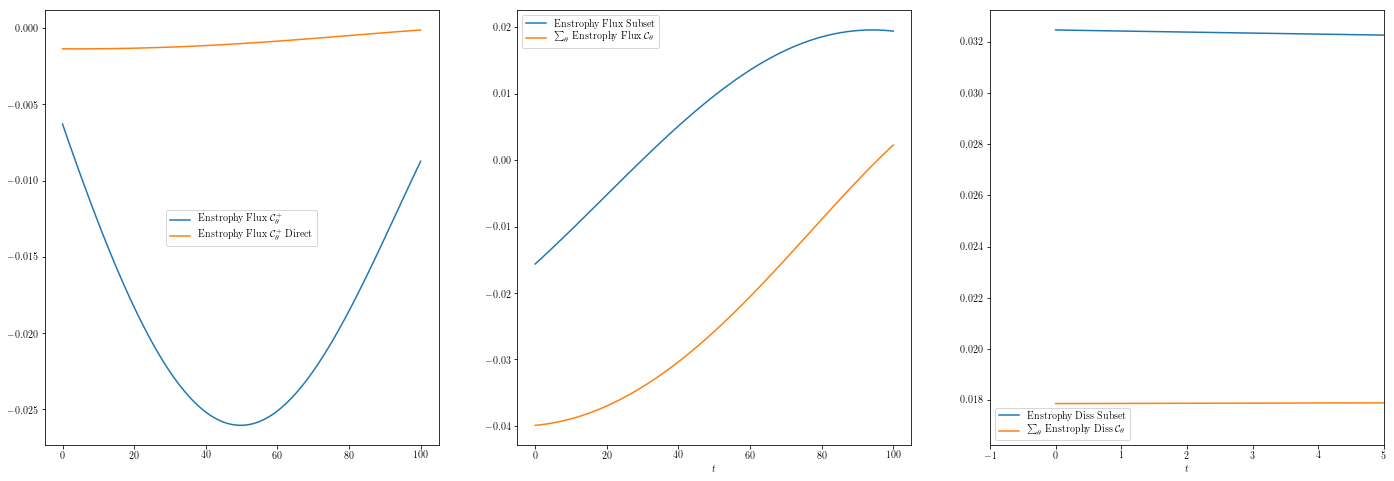

In [397]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2
theta = int(post_data.num_sect // 2)

fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_C_theta[:, theta])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac * norm_fac / 14000)
ax1.legend([r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$", r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$ Direct"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enst_flux_C[:])
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
ax2.set_xlabel(r"$t$")
# ax2.set_xlim(-1, 20)
# ax2.set_yscale('log')
ax2.legend([r"Enstrophy Flux Subset", r"$\sum_\theta$ Enstrophy Flux $\mathcal{C}_\theta$", r"Total Enstrophy"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(post_data.enst_diss_C[:])
ax3.plot(np.sum(post_data.enst_diss_C_theta[:, 1:], axis = -1))
# ax3.set_yscale('log')
ax3.set_xlim(-1, 5)
ax3.set_xlabel(r"$t$")
ax3.legend([r"Enstrophy Diss Subset", r"$\sum_\theta$ Enstrophy Diss $\mathcal{C}_\theta$", r"Total Enstrophy"])

plt.show()


## NOTE: There is a discrepency between the two methods because the way the spectrum index is computed you take the sqrt and round so some modes
## are included that aren't in C.

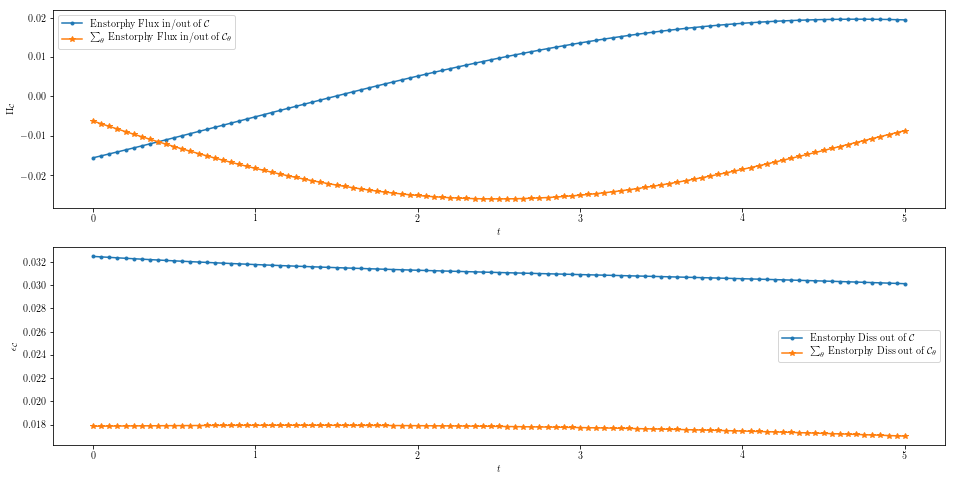

In [398]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(run_data.time, post_data.enst_flux_C[:], '.-')
ax1.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, 1:], axis = 1), '*-')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"Enstorphy Flux in/out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Flux in/out of $\mathcal{C}_\theta$"])
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(run_data.time, post_data.enst_diss_C[:], '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_diss_C_theta[:, 1:], axis = 1), '*-')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\epsilon_{\mathcal{C}}$")
ax2.legend([r"Enstorphy Diss out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Diss out of $\mathcal{C}_\theta$"])
plt.show()

## Compare Spectra Between Post & Solver 

In [399]:
 t = 50

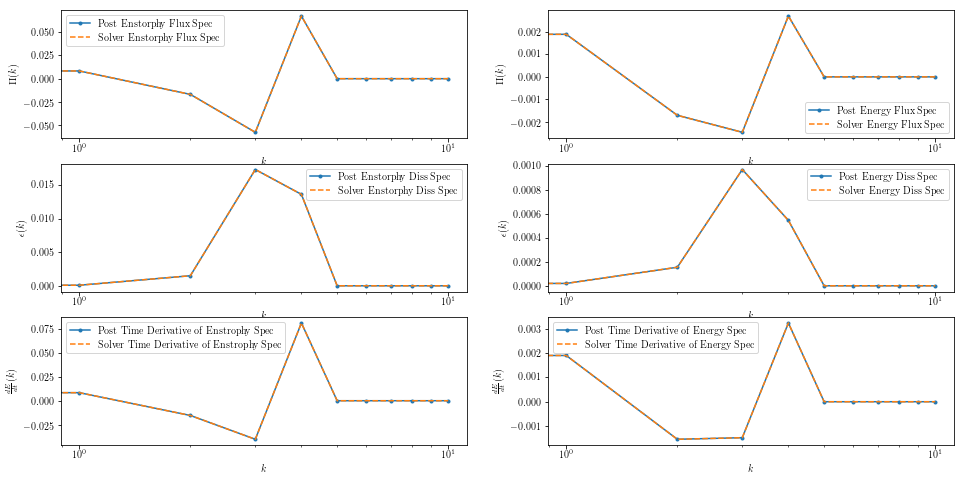

In [400]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_spec[t, 1:], '.-')
ax1.plot(spec_data.enst_flux_spectrum[t, 1:], '--')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\Pi(k)$")
ax1.set_xscale('log')
ax1.legend([r"Post Enstorphy Flux Spec", r"Solver Enstorphy Flux Spec"])
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enrg_flux_spec[t, 1:], '.-')
ax2.plot(spec_data.enrg_flux_spectrum[t, 1:], '--')
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\Pi(k)$")
ax2.set_xscale('log')
ax2.legend([r"Post Energy Flux Spec", r"Solver Energy Flux Spec"])
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(post_data.enst_diss_spec[t, 1:], '.-')
ax3.plot(spec_data.enst_diss_spectrum[t, 1:] , '--')
ax3.set_xlabel(r"$k$")
ax3.set_ylabel(r"$\epsilon(k)$")
ax3.set_xscale('log')
ax3.legend([r"Post Enstorphy Diss Spec", r"Solver Enstorphy Diss Spec"])
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(post_data.enrg_diss_spec[t, 1:], '.-')
ax4.plot(spec_data.enrg_diss_spectrum[t, 1:] , '--')
ax4.set_xlabel(r"$k$")
ax4.set_ylabel(r"$\epsilon(k)$")
ax4.set_xscale('log')
ax4.legend([r"Post Energy Diss Spec", r"Solver Energy Diss Spec"])
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(post_data.d_enst_dt_spec[t, 1:], '.-')
ax5.plot(spec_data.d_enst_dt_spectrum[t, 1:] , '--')
ax5.set_xlabel(r"$k$")
ax5.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax5.set_xscale('log')
ax5.legend([r"Post Time Derivative of Enstrophy Spec", r"Solver Time Derivative of Enstrophy Spec"])
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(post_data.d_enrg_dt_spec[t, 1:], '.-')
ax6.plot(spec_data.d_enrg_dt_spectrum[t, 1:] , '--')
ax6.set_xlabel(r"$k$")
ax6.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax6.set_xscale('log')
ax6.legend([r"Post Time Derivative of Energy Spec", r"Solver Time Derivative of Energy Spec"])
plt.show()

## Compare Enstorphy Flux in C_theta - Combing 1D and 2D Contributions

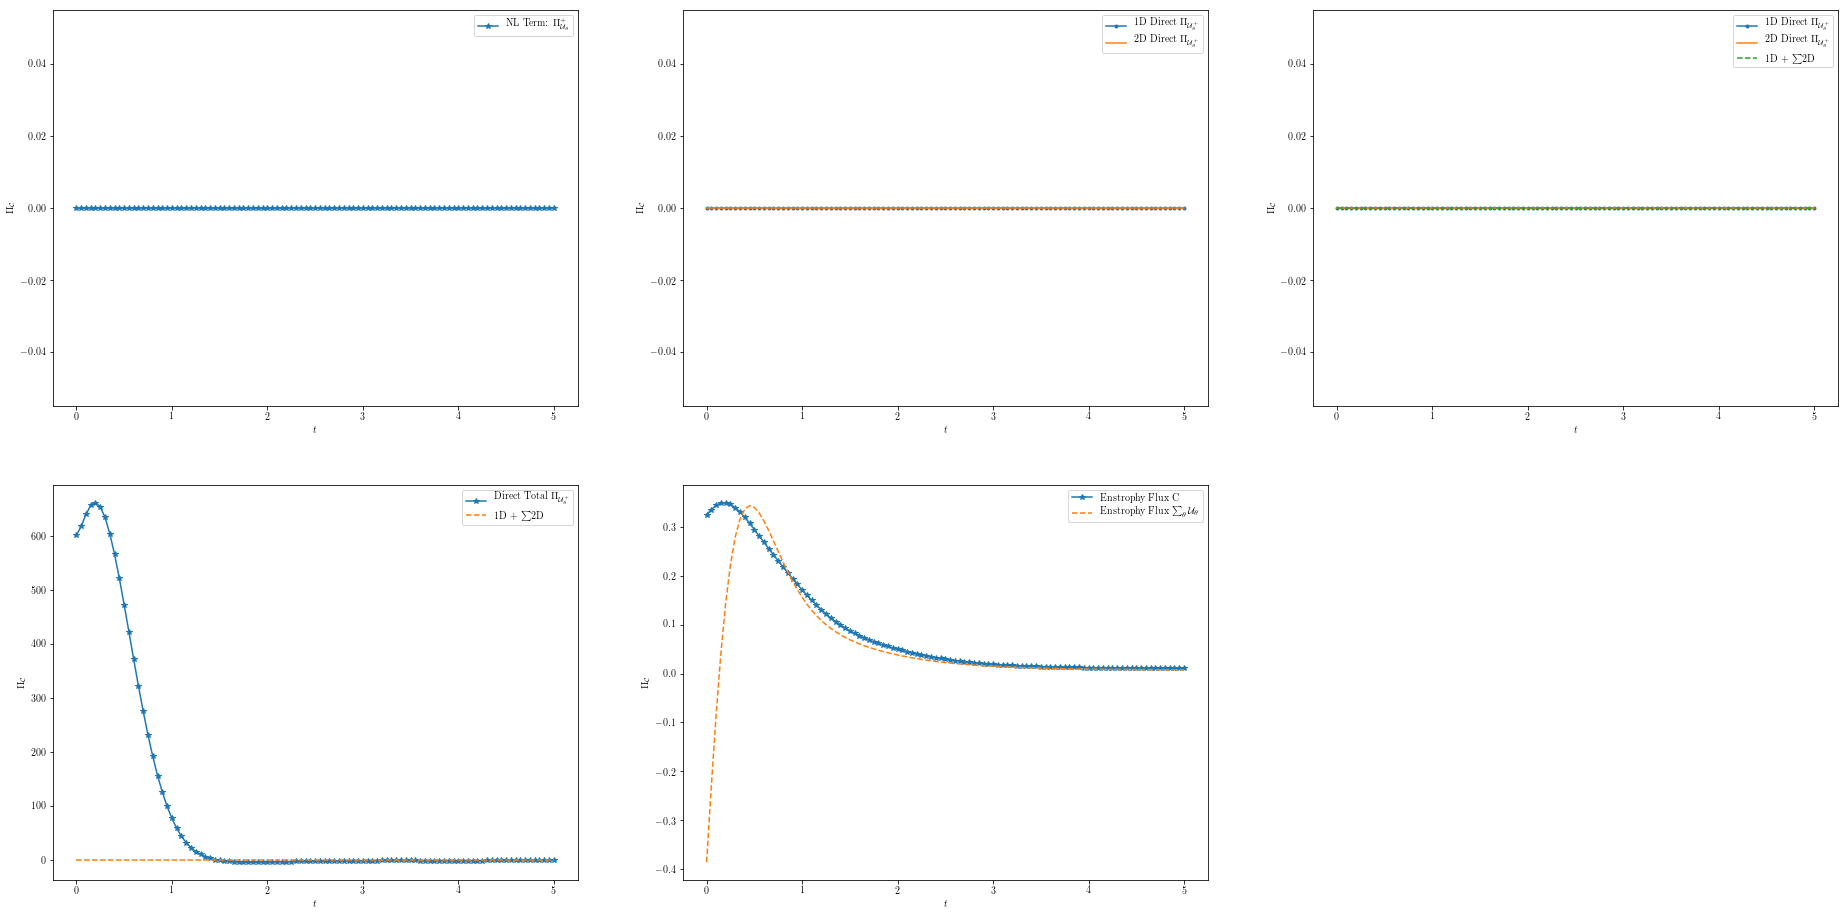

In [51]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2

theta = int(post_data.num_sect//2)

fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, theta],  '.-')
ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, -1], '*-' )
# ax1.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta], '*-') #  * norm_fac * const_fac / 10
# ax1.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
# ax1.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax1.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"NL Term: $\Pi_{\mathcal{U}_\theta}^{+}$", r"Direct Total $\Pi_{\mathcal{U}_\theta}^{+}$"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax2.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax2.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax3.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
ax3.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax3.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta] * norm_fac * const_fac / 10, '*-')
ax4.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax4.set_xlabel(r"$t$")
ax4.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax4.legend([r"Direct Total $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(run_data.time, post_data.enst_flux_C[:], '*-')
ax5.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '--')
ax5.set_xlabel(r"$t$")
ax5.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax5.legend([r"Enstrophy Flux C", r"Enstrophy Flux $\sum_\theta \mathcal{U}_\theta$"])
plt.show()

# r"$\Pi_{\mathcal{U}_\theta^{+}}$: Enstorphy Flux in/out of $\mathcal{U}_\theta^{+}$", 

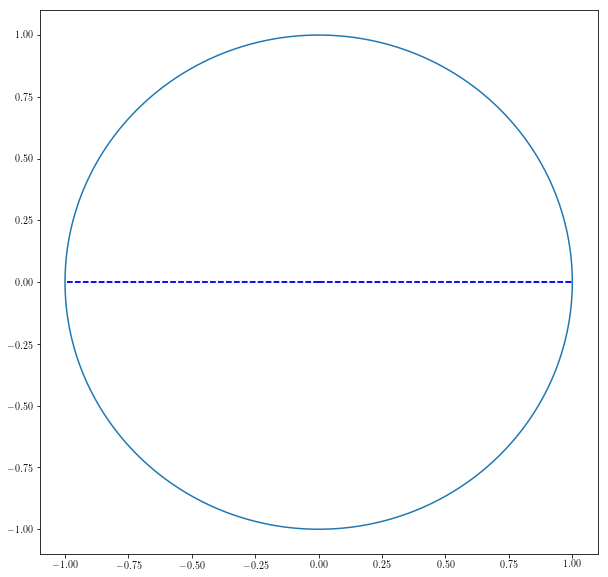

In [274]:
R = 1
angle = np.linspace(0.0, 2.0 * np.pi, 256)

x = R * np.cos(angle)
y = R * np.sin(angle)
dtheta = 2*np.pi/post_data.num_sect
fig = plt.figure(figsize = (10, 10))
plt.plot(x, y)
for i, a in enumerate(post_data.theta):
    plt.plot([0.0, R * np.cos(a - dtheta/2)], [0.0, R * np.sin(a - dtheta/2)], 'b--')
    plt.plot([0.0, R * np.cos(a + dtheta/2)], [0.0, R * np.sin(a + dtheta/2)], 'b--')    

In [38]:
Nx     = sys_vars.Nx
Ny     = sys_vars.Ny
kmax   = post_data.kmax
C_kmax = post_data.kmax_C

for k3_x in range(-Nx//2 + 1, Nx//2 + 1):
    for k3_y in range(-Nx//2 + 1, Nx//2 + 1):
        
        ## Compute polar data for k3
        k3_sqr = k3_x**2 + k3_y**2
        k3_ang = np.arctan2(k3_x, k3_y)
        k3_ang_neg = np.arctan2(-k3_x, -k3_y)
        
        if (k3_sqr > C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)
                    
        elif (k3_sqr <= C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)